# Machine learning - sprint 1
authors: Allart Ewoud, Van Hees Maxime, Breda Bram

#### GET AN INTIAL FEEL OF THE DATA? MOET DIT ER NOG BIJ OF NIET? --> LABO 1

## Importing data

In [1]:
# Import pandas and read csv using pandas
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
from math import nan

In [2]:


original_df = pd.read_csv("tripadvisor_dataset/restaurant_listings.csv")

# display the data and see how it formulated
pd.set_option("display.max_columns", None)
original_df.head()

,rank,restaurant name,general rating,number of reviews,tags,address,phone number,website url,menu url,timetable,email address,travelers choice,michelin,food rating,service rating,value rating,atmosphere rating,description,dutch description,price range,cuisines,special diets,meals,restaurant features,id
0,#1,Kin Khao - Thai Eatery,5.0 of 5 bubbles,922 reviews,$$ - $$$|Thai|Healthy|Vegetarian Friendly,"Donkersteeg 21-23, Ghent 9000 Belgium",+32 468 10 59 59,http://www.kinkhao.be/,http://www.kinkhao.be/site/menu/,True,gent@kinkhao.be,True,False,5.0,5.0,4.5,-1.0,"Differing from formal dining establishments, K...",NaN,€10 - €28,"Thai, Healthy","Vegetarian Friendly, Vegan Options, Gluten Fre...","Dinner, Drinks","Reservations, Seating, Serves Alcohol, Free Wi...",13969825
1,#1,'t Sleutelgat,5.0 of 5 bubbles,200 reviews,$$$$|French|Belgian|European,"Kasseide 78, Ninove 9400 Belgium",+32 54 56 63 09,http://www.restaurant-sleutelgat.be/,NaN,True,restaurant_sleutelgat@telenet.be,False,True,5.0,5.0,4.5,5.0,NaN,NaN,€32 - €74,"French, Belgian, European","Vegetarian Friendly, Vegan Options, Gluten Fre...","Lunch, Dinner","Free Wifi, Reservations, Outdoor Seating, Seat...",740727
2,#2,Royal India Restaurant,4.5 of 5 bubbles,774 reviews,$$ - $$$|Indian|Asian|Vegetarian Friendly,"Donkersteeg 19 Near hotel novotel gent, Ghent ...",+32 497 40 78 27,NaN,NaN,True,royalindiabelgium@gmail.com,True,False,4.5,4.5,4.5,-1.0,"For fresh ingredients and bold flavour, dine i...",NaN,€15 - €30,"Indian, Asian","Vegetarian Friendly, Vegan Options, Gluten Fre...","Lunch, Dinner, Late Night, Drinks","Takeout, Reservations, Seating, Highchairs Ava...",12188645
3,#3,Roots,5.0 of 5 bubbles,282 reviews,$$ - $$$|Belgian|European|Healthy,"Vrouwebroersstraat 5, Ghent 9000 Belgium",+32 9 310 67 73,http://www.rootsgent.be/,NaN,True,Info@rootsgent.be,True,True,5.0,4.5,5.0,-1.0,NaN,NaN,€40 - €80,"Belgian, European, Healthy",NaN,"Lunch, Dinner","Reservations, Outdoor Seating, Seating, Serves...",9710340
4,#1,Mirage,4.5 of 5 bubbles,240 reviews,$$ - $$$|French|Belgian|Dutch,"Brusselsestraat 99, Dendermonde 9200 Belgium",+32 52 55 48 26,http://mirage-ma.be/,http://mirage-ma.be/feestdagenmenus/,True,contact@mirage-ma.be,True,False,4.5,4.5,4.5,-1.0,NaN,NaN,€16 - €64,"French, Belgian, Dutch, Seafood, European","Vegetarian Friendly, Vegan Options, Gluten Fre...","Lunch, Dinner","Accepts Visa, Reservations, Outdoor Seating, S...",8298124


## Split in test & train data

The goal of machine learning is to build models on train data that are able to make predictions on unseen test data. So we first try to split our data into a trainset and a test set before we move on to the other steps.

In [3]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(original_df, random_state=0, train_size = 0.8)
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df = df_train.select_dtypes(include=numerics)

## Data clean-up

First we start with cleaning of the less complicated data. This includes the collumns general rating, number of reviews and rank.

### General rating, number of reviews & rank

In [4]:
# general rating
df["general rating"] = df_train["general rating"].apply(lambda x: float(str(x).split(' ')[0]))
df["general rating"] = pd.to_numeric(df["general rating"])

# number of reviews
df["number of reviews"] = df_train["number of reviews"].apply(lambda x: int(str(x).split(' ')[0]))
df["number of reviews"] = pd.to_numeric(df["number of reviews"])

# rank
df["rank"] = df_train["rank"].str.split("#").str[1]
df["rank"] = pd.to_numeric(df["rank"])

df.head()

,food rating,service rating,value rating,atmosphere rating,id,general rating,number of reviews,rank
220,4.0,4.0,4.0,4.0,1127788,4.0,179,119.0
1103,4.0,3.5,3.5,-1.0,12272003,3.5,79,430.0
17,4.5,4.5,4.5,4.0,784367,4.5,254,11.0
58,4.5,4.5,4.5,-1.0,8279642,4.5,120,1.0
847,4.0,4.5,4.5,-1.0,10037978,4.5,20,26.0


### Restaurants with no reviews

2 options:

- we remove the restaurants that have no reviews, and thus nu general rating. But will this impact the model we will train later on? 

```df2 = df.loc[(df['number of reviews'] == 0) & (df['general rating'] == -1.0)]```

- we don't remove them and assume the model will learn by itself that these entries aren't that useful.

### Price range
A collumn that is a bit more complicated is price range, this collumn will be split in 2, after this the average is taken.

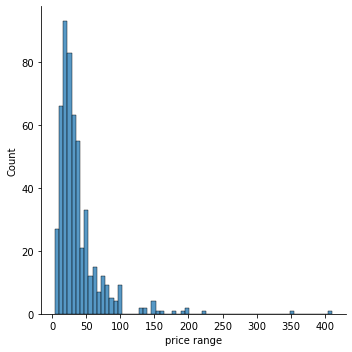

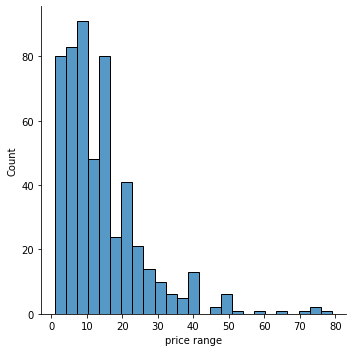

In [5]:
upper_bound = df_train["price range"].str.split(" - ").str[1]
upper_bound = upper_bound.str.split('€').str[1]
upper_bound = pd.to_numeric(upper_bound)

lower_bound = df_train["price range"].str.split(" - ").str[0]
lower_bound = lower_bound.str.split('€').str[1]
lower_bound = pd.to_numeric(lower_bound)

sn.displot(upper_bound)
sn.displot(lower_bound)

,food rating,service rating,value rating,atmosphere rating,id,general rating,number of reviews,rank,price range
220,4.0,4.0,4.0,4.0,1127788,4.0,179,119.0,0.0
1103,4.0,3.5,3.5,-1.0,12272003,3.5,79,430.0,NaN
17,4.5,4.5,4.5,4.0,784367,4.5,254,11.0,0.0
58,4.5,4.5,4.5,-1.0,8279642,4.5,120,1.0,0.0
847,4.0,4.5,4.5,-1.0,10037978,4.5,20,26.0,NaN


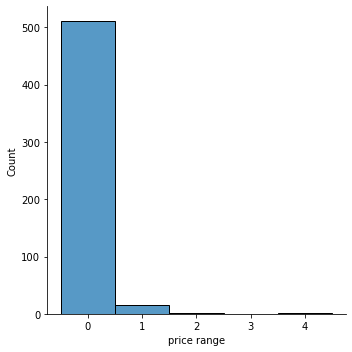

In [6]:
from sklearn import preprocessing

average = (upper_bound-lower_bound)/2

transformer = preprocessing.FunctionTransformer(pd.cut, kw_args={'bins': 5, 'labels': [0, 1, 2, 3, 4], 'retbins': True})
avg_quantfied = transformer.fit_transform(average)

#visualize the data
sn.displot(avg_quantfied[0])

df['price range'] =  pd.to_numeric(avg_quantfied[0])
df.head()

### Food, service & value rating
As we can see in the next scatter matrix (diagonal), food, service & value rating have a lot of -1 values. 


array([[<AxesSubplot:xlabel='food rating', ylabel='food rating'>,
        <AxesSubplot:xlabel='service rating', ylabel='food rating'>,
        <AxesSubplot:xlabel='value rating', ylabel='food rating'>],
       [<AxesSubplot:xlabel='food rating', ylabel='service rating'>,
        <AxesSubplot:xlabel='service rating', ylabel='service rating'>,
        <AxesSubplot:xlabel='value rating', ylabel='service rating'>],
       [<AxesSubplot:xlabel='food rating', ylabel='value rating'>,
        <AxesSubplot:xlabel='service rating', ylabel='value rating'>,
        <AxesSubplot:xlabel='value rating', ylabel='value rating'>]],
      dtype=object)

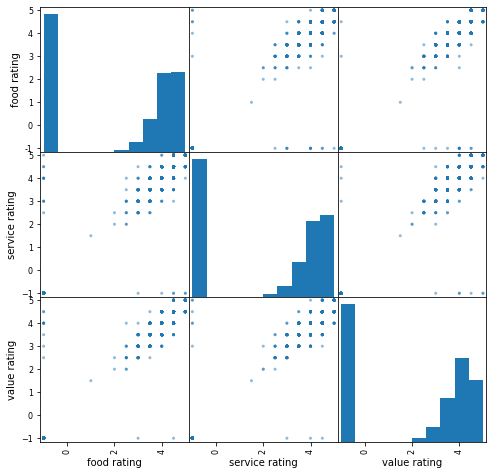

In [7]:
pd.plotting.scatter_matrix(df[["food rating","service rating","value rating"]], figsize = (8,8))

This is something that needs to be solved, -1 is not a valid rating. There are a few option that can solve this issue: 
- Drop the rows with a -1 value
- Drop the column 
- Change the value to a meaningfull value like zero, mean, medain, etc.

Dropping the rows would result in alot of data being lost. Droping the column may result an in a a valueble feature being lost, so the best option is changing it for a meanigfull value. In this case median and mean are 2 candidats.

In [8]:
mean = df["service rating"].loc[df["service rating"] != -1].mean()
df["service rating"] = df["service rating"].replace(-1,mean)

mean = df["food rating"].loc[df["food rating"] != -1].mean()
df["food rating"] = df["food rating"].replace(-1,mean)

mean = df["value rating"].loc[df["value rating"] != -1].mean()
df["value rating"] = df["value rating"].replace(-1,mean)

df.head()

,food rating,service rating,value rating,atmosphere rating,id,general rating,number of reviews,rank,price range
220,4.0,4.0,4.0,4.0,1127788,4.0,179,119.0,0.0
1103,4.0,3.5,3.5,-1.0,12272003,3.5,79,430.0,NaN
17,4.5,4.5,4.5,4.0,784367,4.5,254,11.0,0.0
58,4.5,4.5,4.5,-1.0,8279642,4.5,120,1.0,0.0
847,4.0,4.5,4.5,-1.0,10037978,4.5,20,26.0,NaN


array([[<AxesSubplot:xlabel='food rating', ylabel='food rating'>,
        <AxesSubplot:xlabel='service rating', ylabel='food rating'>,
        <AxesSubplot:xlabel='value rating', ylabel='food rating'>],
       [<AxesSubplot:xlabel='food rating', ylabel='service rating'>,
        <AxesSubplot:xlabel='service rating', ylabel='service rating'>,
        <AxesSubplot:xlabel='value rating', ylabel='service rating'>],
       [<AxesSubplot:xlabel='food rating', ylabel='value rating'>,
        <AxesSubplot:xlabel='service rating', ylabel='value rating'>,
        <AxesSubplot:xlabel='value rating', ylabel='value rating'>]],
      dtype=object)

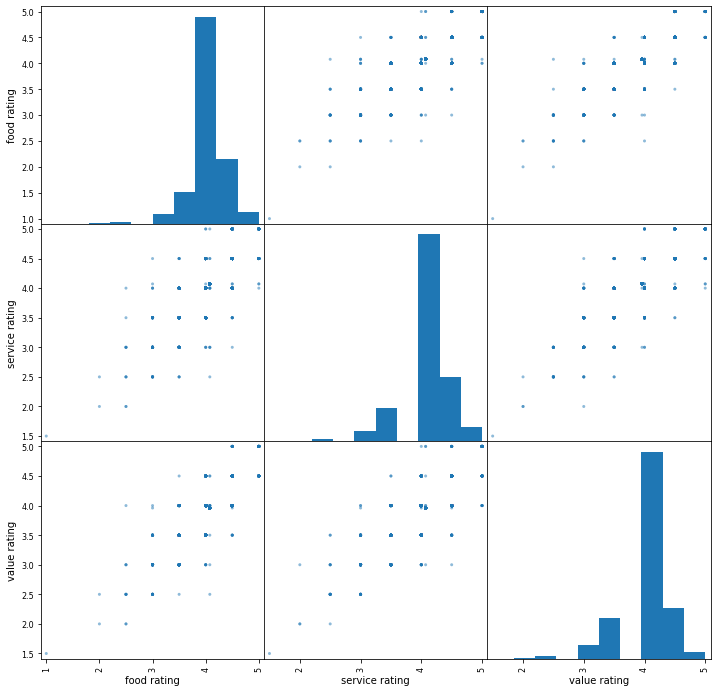

In [9]:
pd.plotting.scatter_matrix(df[["food rating","service rating","value rating"]], figsize = (12,12))

### Meals

In [10]:
# Getting all different types off meals
types = []
for i in df_train['meals'].fillna(value=""):
    types.extend(map(lambda x: x.strip(), i.split(",")))
types = set(types)


# For every type we are going to create a collumn that represents the type
for i in types:
    if i != "":
        df[i] = df_train["meals"].apply(lambda x: str(x)).apply(lambda x: int(i in x))

# displays full table
#with pd.option_context('display.max_rows', None, 'display.max_columns', None): display(df)
df.head()

,food rating,service rating,value rating,atmosphere rating,id,general rating,number of reviews,rank,price range,Dinner,Breakfast,Lunch,Drinks,Late Night,Brunch
220,4.0,4.0,4.0,4.0,1127788,4.0,179,119.0,0.0,1,0,1,0,1,0
1103,4.0,3.5,3.5,-1.0,12272003,3.5,79,430.0,NaN,1,0,0,0,0,0
17,4.5,4.5,4.5,4.0,784367,4.5,254,11.0,0.0,1,0,0,0,0,0
58,4.5,4.5,4.5,-1.0,8279642,4.5,120,1.0,0.0,1,0,1,0,0,0
847,4.0,4.5,4.5,-1.0,10037978,4.5,20,26.0,NaN,1,0,0,0,0,0


#### <font color='red'>VRAAG: kunnen we de opties reduceren, bv brunch & breakfast? Later hiernaar kijken</font>

### Cuisines

In [11]:
types = []
for i in df_train['cuisines'].fillna(value=""):
    types.extend(map(lambda x: x.strip(), i.split(",")))
types = set(types)
print("Amount of different cuisines:",len(types))

# prints the amout of times a cuisine occurs in the data
# set _print on True to enable printing of frequencies
_print = True


freq = {}
for i in types:  
    if i != "":
        freq[i] = df_train["cuisines"].apply(lambda x: str(x)).apply(lambda x: int(i in x)).sum()


#print("\n")
#print("-"*20, "frequency tabel", "-"*20) 
#for key, value in freq.items():
#    print('{:<25}'.format(key ), '{:>4}'.format(value) , "times")
percentile75 = np.quantile(list(freq.values()), 0.75)
percentile50 = np.quantile(list(freq.values()), 0.5)

print("50-percentile:",percentile50)
print("75-percentile:",percentile75)


freq = { key:value for (key,value) in freq.items() if value > percentile50}

for (key,value) in freq.items():
    if key != "":
        df[key] = df_train["cuisines"].apply(lambda x: int(key in str(x)))
   
#TODO add others collumn
df

Amount of different cuisines: 93
50-percentile: 6.0
75-percentile: 37.5


,food rating,service rating,value rating,atmosphere rating,id,general rating,number of reviews,rank,price range,Dinner,Breakfast,Lunch,Drinks,Late Night,Brunch,Mexican,Barbecue,Mediterranean,Vietnamese,Fast Food,European,Middle Eastern,Pub,American,Deli,Dutch,Italian,Diner,Lebanese,Pizza,Sicilian,Steakhouse,Fusion,Southern-Italian,French,Wine Bar,Indian,Sushi,Japanese,Belgian,Greek,Japanese Fusion,Cafe,Contemporary,Central European,Turkish,Grill,Street Food,Bar,Asian,Seafood,Soups,Spanish,Gastropub,South American,International,Chinese,Healthy,Dining bars,Thai
220,4.000000,4.000000,4.000000,4.0,1127788,4.0,179,119.0,0.0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1103,4.000000,3.500000,3.500000,-1.0,12272003,3.5,79,430.0,NaN,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17,4.500000,4.500000,4.500000,4.0,784367,4.5,254,11.0,0.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
58,4.500000,4.500000,4.500000,-1.0,8279642,4.5,120,1.0,0.0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
847,4.000000,4.500000,4.500000,-1.0,10037978,4.5,20,26.0,NaN,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,4.000000,4.500000,4.000000,-1.0,14107034,4.0,19,1.0,0.0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1731,4.077579,4.071197,3.959241,-1.0,14051083,3.5,9,587.0,NaN,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
763,4.000000,4.000000,3.500000,4.0,3820132,3.5,101,4.0,NaN,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
835,4.000000,3.500000,4.000000,4.5,3614874,4.0,107,41.0,NaN,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


The boxplot shows the distribution of the frequencies of the cuisines. Here we can see that a lot of cuisines occur only a few times. This may presents an oppertunity to reduce these to a categorie like "others".

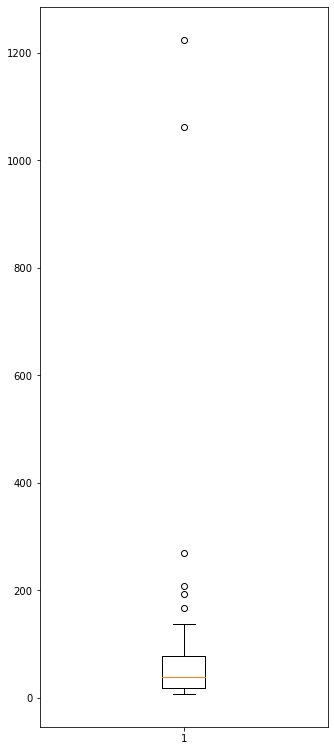

In [12]:
fig = plt.figure(figsize =(4, 10))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(freq.values())
plt.show()  

### Address

The address field has the following structure in most cases:
    1. Streetname + number + ","
    2. City + corresponding postal code
    3. Country (here Belgium in all cases)
Upon closer inspection we can see that sometimes field 1. and 2. are comma-separted, sometimes not.
The number behind the streetname sometimes consists of two numbers (can be split with ' ' or '-' or '/' or ...)

In [13]:
df2 = df_train

# Let's start by stripping 'Belgium'
df2["address"] = df2["address"].str.rstrip("Belgium")
# Enkel nog de gemeente/stad overhouden
#df2["address"] = df2["address"].str.split(",").str[1]
#df2["address"] = df2["address"].str.split(" ").str[0]
df2.head()

,rank,restaurant name,general rating,number of reviews,tags,address,phone number,website url,menu url,timetable,email address,travelers choice,michelin,food rating,service rating,value rating,atmosphere rating,description,dutch description,price range,cuisines,special diets,meals,restaurant features,id
220,#119,Vier tafels,4.0 of 5 bubbles,179 reviews,$$ - $$$|Belgian|International|European,"Plotersgracht 6, Ghent 9000",+32 9 225 05 25,http://www.viertafels.be/,http://viertafels.be/middeleeuws-restaurant-ex...,True,viertafels@gmail.com,False,False,4.0,4.0,4.0,4.0,"The restaurant started in 1981, and is the old...",NaN,€38 - €53,"European, Belgian, International, Fusion",Vegetarian Friendly,"Lunch, Dinner, Late Night","Reservations, Seating, Wheelchair Accessible, ...",1127788
1103,#430,Basta,3.5 of 5 bubbles,79 reviews,$$ - $$$|Mediterranean|European|Vegetarian Fri...,Zuidstationstraat 2 Hoek Sint Anna met Brabant...,+32 9 336 70 75,http://www.bastaresto.com/,http://www.bastaresto.com/#menu,False,NaN,False,False,4.0,3.5,3.5,-1.0,NaN,NaN,No pricing available,"Mediterranean, European",Vegetarian Friendly,Dinner,"Reservations, Seating, Highchairs Available, W...",12272003
17,#11,A Food Affair,4.5 of 5 bubbles,254 reviews,$$ - $$$|Asian|Thai|Vietnamese,"Hoogstraat 58, Ghent 9000",+32 9 224 18 05,http://www.afoodaffair.be/,https://www.afoodaffair.be/menu/,True,NaN,False,True,4.5,4.5,4.5,4.0,NaN,NaN,€40 - €80,"Vietnamese, Asian, Thai","Vegan Options, Vegetarian Friendly",Dinner,"Full Bar, Reservations, Outdoor Seating, Seati...",784367
58,#1,Eat@12,4.5 of 5 bubbles,120 reviews,$$ - $$$|Belgian|Dutch|European,"Doorn 12, Oudenaarde 9700",+32 55 31 13 45,http://www.eat12.be/,https://www.eat12.be/menu/,True,doorn12@aarova.be,False,False,4.5,4.5,4.5,-1.0,NaN,NaN,€15 - €33,"Belgian, European, Dutch",Vegetarian Friendly,"Lunch, Dinner","Reservations, Outdoor Seating, Seating, Parkin...",8279642
847,#26,Dalmacija,4.5 of 5 bubbles,20 reviews,$$ - $$$|European|Croatian,"Onze-Lieve-Vrouwplein 3, Sint-Niklaas 9100",+32 3 777 37 12,http://www.nieuwsblad.be/cnt/dmf20121219_00407757,http://www.nieuwsblad.be/cnt/dmf20121219_00407...,False,NaN,False,False,4.0,4.5,4.5,-1.0,NaN,NaN,No pricing available,"Croatian, European",NaN,Dinner,"Reservations, Seating, Table Service",10037978


### Restaurant features

Extract different restaurant feautures from the dataset

Amount of features: 39


<AxesSubplot:>

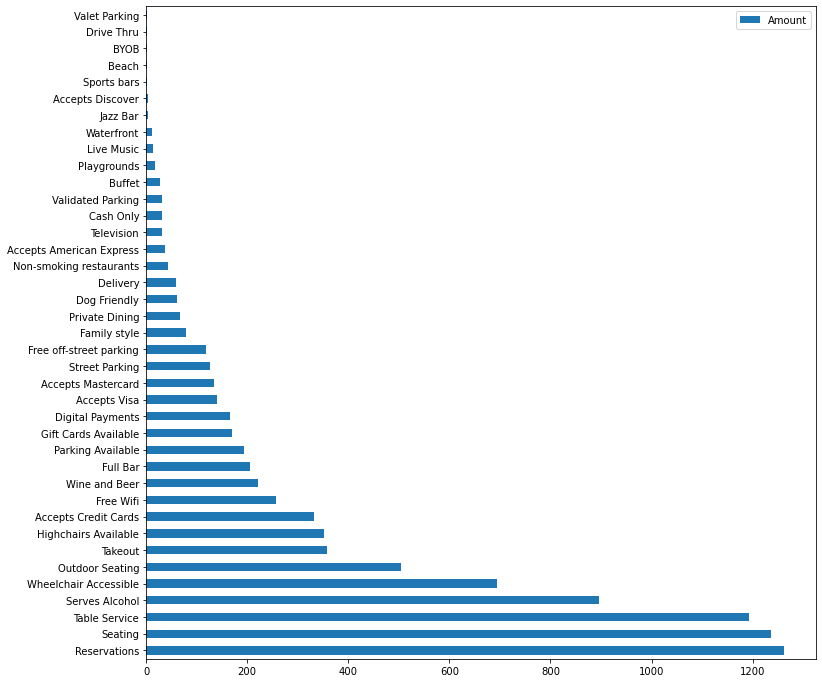

In [14]:
# Create a dict that holds all restaurant feautures and how much they appear
feature_types = {}
for i in df_train['restaurant features'].fillna(value=""):
    for f in i.split(','):
        if i != "":
            if f.strip() in feature_types.keys():
                feature_types[f.strip()] += 1
            else:
                feature_types[f.strip()] = 1
           
print("Amount of features:" , len(feature_types.keys()))

# omzetten naar dataframe
df_features = pd.DataFrame(feature_types, index=[0]).transpose()
df_features.columns = ['Amount']
df_features.sort_values(['Amount'], ascending=False, inplace=True)
df_features.plot(kind='barh', figsize=(12,12))

### Special Diets

Amount of diets: 5
{'Vegetarian Friendly': 685, 'Vegan Options': 167, '': 1366, 'Gluten Free Options': 145, 'Halal': 4}
Average review score per diet type {'Vegetarian Friendly': 4.086131386861314, 'Vegan Options': 4.254491017964072, '': 4.086676217765043, 'Gluten Free Options': 4.2620689655172415}


<AxesSubplot:title={'center':'Average review score per diet'}>

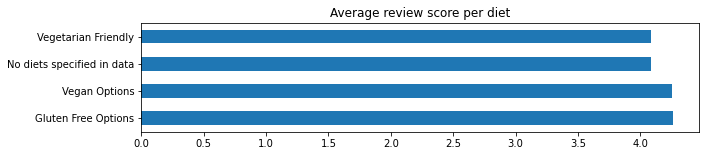

In [15]:
# check which special diets exist in the data
diet_types = {}
for i in df_train['special diets'].fillna(value=""):
    for f in i.split(','):
            if f.strip() in diet_types.keys():
                diet_types[f.strip()] += 1
            else:
                diet_types[f.strip()] = 1
           
print("Amount of diets:" , len(diet_types.keys()))
print(diet_types)

# check if available diet options have influence on the average rating per restaurant
diet_avg_review = {}
for d in diet_types.keys():
    if len(df_train[df_train['special diets'].str.contains(d) == True]) >=  100: #only use data of a diet type if there are more than 100 restaurants with that diet type
        diet_avg_review[d] = df[df_train['special diets'].str.contains(d) == True]['general rating'].mean()
print('Average review score per diet type',diet_avg_review)
df_diets = pd.Series(diet_avg_review).rename({'': 'No diets specified in data'})
df_diets.sort_values(ascending=False).plot(kind='barh', figsize=(10,2), title='Average review score per diet')


The graph above shows that restaurants with vegan and gluten free options have a higher average review score. 

In [25]:
price_options = []

for i in df_train['tags'].fillna(value=""):
    for j in i.split('|'):
        if '$' in j:
            price_options.append(j)
            
price_options = set(price_options)
price_options = sorted(price_options, key= lambda x: len(x.split('-')[0].strip()))
       
def formatPriceRange(tags):
    for i in reversed(range(0,3)):
        if price_options[i] in tags:
            return i + 1
    return nan
       
df["price tag"] = df_train['tags'].apply(lambda x: formatPriceRange(str(x)))
df["price tag"].value_counts()
        

#df["price range alternative"] = df_train['tags'].apply(lambda x: formatPriceRange(str(x)))

#print(count)
#with pd.option_context('display.max_rows', None, 'display.max_columns', None): display(df.sort_values(by=["price range alternative"]))

2.0    1239
1.0     255
3.0      63
Name: price tag, dtype: int64